In [1]:
pwd

'C:\\Users\\saadatumk\\Desktop\\thinkbox\\Sythetic data generation\\Synthetic Data Generation\\syn_data_gen_codes\\3D Image Generation'

In [2]:
from matplotlib import pyplot as plt
from PIL import Image
import torch
from transformers import GLPNImageProcessor,GLPNForDepthEstimation

In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [4]:
#getting model
feature_extractor=GLPNImageProcessor.from_pretrained("vinvino02/glpn-nyu")
model=GLPNForDepthEstimation.from_pretrained("vinvino02/glpn-nyu")

In [5]:
image=Image.open(r"C:\Users\saadatumk\Desktop\thinkbox\Sythetic data generation\Synthetic Data Generation\syn_data_gen_codes\3D Image Generation\cube sample.jpg")
new_height=480 if image.height>480 else image.height
new_height-=(new_height % 32)
new_width=int(new_height*image.width/image.height)
diff=new_width % 32

In [6]:
new_width=new_width-diff if diff<36 else new_width +32 - diff
new_size=(new_width,new_height)
image=image.resize(new_size)

In [7]:
#preparing image for model
inputs=feature_extractor(images=image,return_tensors="pt")
#getting prediction from model
with torch.no_grad():
    outputs=model(**inputs)
    predicted_depth=outputs.predicted_depth
    


In [8]:
#post processing
pad=16
output=predicted_depth.squeeze().cpu().numpy()*1000.0
output=output[pad:-pad,pad:-pad]
image=image.crop((pad,pad,image.width-pad,image.height-pad))

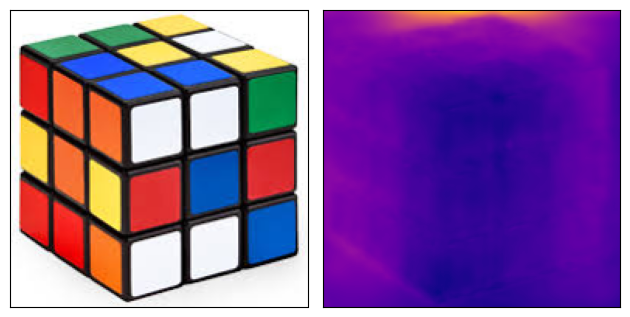

In [9]:
#plot predicction
fig,ax=plt.subplots(1,2)
ax[0].imshow(image)
ax[0].tick_params(left=False,bottom=False, labelleft=False, labelbottom=False)
ax[1].imshow(output,cmap='plasma')
ax[1].tick_params(left=False,bottom=False, labelleft=False, labelbottom=False)
plt.tight_layout()



In [10]:
#point cloud generation
#importing the libraries

import numpy as np
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [11]:
#preparing depth image for open 3d
width,height=image.size

depth_image=(output*255/np.max(output)).astype('uint8')
image=np.array(image)

In [12]:
#create rgbd image
depth_o3d=o3d.geometry.Image(depth_image)
image_o3d=o3d.geometry.Image(image)
rgbd_image=o3d.geometry.RGBDImage.create_from_color_and_depth(image_o3d,depth_o3d,convert_rgb_to_intensity=False)

In [13]:
#Setting the camera(calibration)
camera_intrinsic=o3d.camera.PinholeCameraIntrinsic()
camera_intrinsic.set_intrinsics(width,height,500,500,width/2,height/2)

In [14]:
#generate o3d point cloud
pcd=o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image,camera_intrinsic)


In [16]:
pcd_raw=o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image,camera_intrinsic)

In [18]:
o3d.visualization.draw_geometries([pcd_raw])

In [22]:
cl,ind=pcd.remove_statistical_outlier(nb_neighbors=20,std_ratio=6.0)
pcd=pcd_raw.select_by_index(ind)

In [23]:
#open 3d mesh
#post processing 3d point cloud
pcd_raw.estimate_normals()
pcd_raw.orient_normals_to_align_with_direction()


In [24]:
pcd

PointCloud with 36662 points.

In [25]:
pcd_raw

PointCloud with 36864 points.

In [26]:
o3d.visualization.draw_geometries([pcd])

In [27]:
#surface reconstruction
mesh=o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd,depth=10,n_threads=1)[0]

In [29]:
rotation=mesh.get_rotation_matrix_from_xyz((np.pi,0,0))
mesh.rotate(rotation,center=(0,0,0))

TriangleMesh with 91903 points and 183509 triangles.

In [30]:
o3d.visualization.draw_geometries([mesh],mesh_show_back_face=True)